# Tutorial: Actor Critic Implementation

In [1]:
#Import required libraries

import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt

In [2]:
#Set constants for training
seed = 543
# seed = 87
log_interval = 10
gamma = 0.99

env = gym.make('CartPole-v1')
env.reset(seed=seed)
torch.manual_seed(seed)

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])


In [3]:
env = gym.make('CartPole-v1')
env.reset(seed=seed)
torch.manual_seed(seed)


SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])


class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)

        # actor's layer
        self.action_head = nn.Linear(128, 2)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values


In [4]:
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()

In [5]:

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (left or right)
    return action.item()


def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


def train():
    rewards = []
    running_reward = 10

    # run infinitely many episodes
    for i_episode in range(2000):

        # reset environment and episode reward
        state, _ = env.reset()
        ep_reward = 0

        # for each episode, only run 9999 steps so that we don't
        # infinite loop while learning
        for t in range(1, 10000):

            # select action from policy
            action = select_action(state)

            # take the action
            state, reward, done, _, _ = env.step(action)

            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        # update cumulative reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        rewards.append(running_reward)

        # perform backprop
        finish_episode()

        # log results
        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))

		# check if we have "solved" the cart pole problem
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break
    return rewards

In [6]:
def plot(shared_rewards, unshared_rewards, threshold):
    """
    Plot the results of shared and unshared architectures with a horizontal threshold line.

    Args:
        shared_rewards (list): List of average rewards for shared architecture.
        unshared_rewards (list): List of average rewards for unshared architecture.
        threshold (float): Threshold value for the horizontal line.
    """
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(shared_rewards, label='Shared Architecture')
    plt.plot(unshared_rewards, label='Unshared Architecture')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Comparison of Shared vs. Unshared Architectures')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
shared_rewards = train()

/opt/miniconda3/envs/torch/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Last reward: 35.00	Average reward: 11.25
Episode 10	Last reward: 11.00	Average reward: 10.84
Episode 20	Last reward: 10.00	Average reward: 10.33
Episode 30	Last reward: 10.00	Average reward: 10.06
Episode 40	Last reward: 10.00	Average reward: 9.79
Episode 50	Last reward: 10.00	Average reward: 9.59
Episode 60	Last reward: 8.00	Average reward: 9.56
Episode 70	Last reward: 9.00	Average reward: 9.44
Episode 80	Last reward: 11.00	Average reward: 9.65
Episode 90	Last reward: 11.00	Average reward: 9.49
Episode 100	Last reward: 10.00	Average reward: 9.58
Episode 110	Last reward: 9.00	Average reward: 9.51
Episode 120	Last reward: 9.00	Average reward: 9.50
Episode 130	Last reward: 11.00	Average reward: 9.45
Episode 140	Last reward: 9.00	Average reward: 10.21
Episode 150	Last reward: 18.00	Average reward: 23.84
Episode 160	Last reward: 62.00	Average reward: 45.89
Episode 170	Last reward: 35.00	Average reward: 39.74
Episode 180	Last reward: 72.00	Average reward: 57.18
Episode 190	Last re

# TODO: Write a policy class similar to the above, without using shared features for the actor and critic and compare their performance.

In [8]:

#TODO: Write a policy class similar to the above, without using shared features for the actor and critic and compare their
# performance.

class UnsharedPolicy(nn.Module):
	def __init__(self):
		super(UnsharedPolicy, self).__init__()
		#TODO: Fill in.
		# Actor network layers
		self.actor_fc1 = nn.Linear(4, 128)
		self.actor_fc2 = nn.Linear(128, 2)  # 2 actions in CartPole-v1

		# Critic network layers
		self.critic_fc1 = nn.Linear(4, 128)
		self.critic_fc2 = nn.Linear(128, 1)

		# Action & reward buffer
		self.saved_actions = []
		self.rewards = []

	def forward(self, x):
		# TODO: Fill in. For your networks, use the same hidden_size for the layers as the previous policy, that is 128.
		# Actor network
		actor_x = F.relu(self.actor_fc1(x))
		action_probs = F.softmax(self.actor_fc2(actor_x), dim=-1)

		# Critic network
		critic_x = F.relu(self.critic_fc1(x))
		state_value = self.critic_fc2(critic_x)

		# return values for both actor and critic as a tuple of 2 values:
		# 1. a list with the probability of each action over the action space
		# 2. the value from state s_t
		return action_probs, state_value

In [9]:
model = UnsharedPolicy()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()
unshared_rewards = train()

Episode 0	Last reward: 24.00	Average reward: 10.70
Episode 10	Last reward: 24.00	Average reward: 19.47
Episode 20	Last reward: 35.00	Average reward: 23.33
Episode 30	Last reward: 36.00	Average reward: 29.98
Episode 40	Last reward: 33.00	Average reward: 38.66
Episode 50	Last reward: 24.00	Average reward: 39.87
Episode 60	Last reward: 34.00	Average reward: 35.00
Episode 70	Last reward: 51.00	Average reward: 37.74
Episode 80	Last reward: 130.00	Average reward: 61.41
Episode 90	Last reward: 192.00	Average reward: 86.55
Solved! Running reward is now 633.6832365471276 and the last episode runs to 9999 time steps!


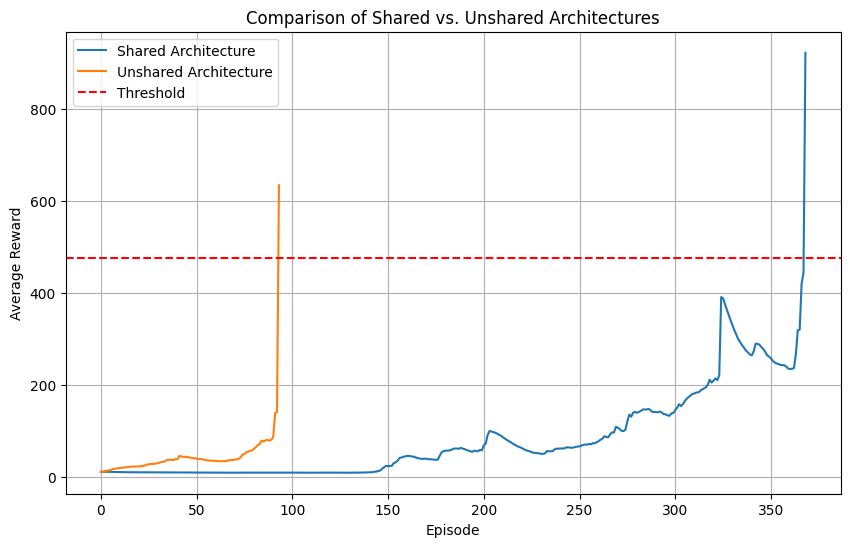

In [10]:
# Plot results
plot(shared_rewards, unshared_rewards, env.spec.reward_threshold)

#### Comparision between the performace of shared and unshared networks in Actor-Critic Method
Each of the policy classes concering a shared and a unshared network in Actor-Critic Method is implemented for CartPole-v1. For shared policy, a fully connected network of size $4$ (Input Layer) $\times 128$ (Hidden Layer) $\times$ $3$ (Output Layer) is used, where 2 of the 3 neurons in the output layer is represented for the actor and the remaining one is used for the critic. Two analogous fully connected networks, one of size $4$ (Input Layer) $\times 128$ (Hidden Layer) $\times$ $2$ (Output Layer) and the other of size $4$ (Input Layer) $\times 128$ (Hidden Layer) $\times$ $1$ (Output Layer)


Learning Speed: The plot shows the average rewards obtained by both architectures over episodes. We can observe how quickly each architecture learns to achieve higher rewards. If one architecture consistently achieves higher rewards earlier in the training process, it indicates faster learning speed.

Convergence: The convergence behavior of both architectures can be analyzed from the plot. A faster convergence implies that an architecture reaches a satisfactory level of performance (e.g., reward threshold) in fewer episodes.

Stability: The stability of learning is crucial for reinforcement learning algorithms. A stable learning process is characterized by smooth and consistent improvements in rewards over episodes without significant fluctuations or instabilities.

Performance Gap: By comparing the final average rewards achieved by both architectures, we can determine if one architecture outperforms the other in terms of task performance. A larger performance gap suggests that one architecture is more effective at learning the task than the other.

Robustness: Robustness refers to the ability of an architecture to generalize its learned policy across different environments or variations of the task. Analyzing the consistency of performance under various conditions can provide insights into the robustness of each architecture.